# Import Packages

In [1]:
# Packages
import uncertainties as unc  
import uncertainties.unumpy as unumpy  
from uncertainties import ufloat
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit 
from scipy import stats

In [2]:
# Initialize Data
with open('data.txt') as f:
    lines = f.readlines()
    t = np.array([float(line.split()[0])*10/3 for line in lines])
    x = np.array([float(line.split()[1])*1.12 for line in lines])
    y = np.array([line.split()[2] for line in lines])

pos =[i for i in x if i>0]
pos = sum(pos)/len(pos)
neg = [i for i in x if i<0]
neg = -sum(neg)/len(neg)
x = np.array([i - (pos-neg) for i in x])

# Errors
err_t = np.array([])

err_t = np.array([0.01 for i in t])
err_x = np.array([0.014/3 for i in x])
err_y = np.array([0.01/3  for i in y])

# Convert to unumpy array for easy error propagation
t = unumpy.uarray(t, err_t)
x = unumpy.uarray(x, err_x)
y = unumpy.uarray(y, err_y)


print("#of Data Points:",len(t))

#of Data Points: 14053


In [3]:
# Determine angle
string_length = ufloat(1.075,0.001)
theta = unumpy.arcsin(x/string_length)

print("The initial angle is: ",theta[0])

The initial angle is:  -1.442+/-0.035


# Plots

In [4]:
def plot(arr_x,arr_y,name,skip=1):
    '''
    Plot graph of two unumpy arrays
    '''
    title = f"figures/{name}.png"
    plt.rcParams.update({'font.size': 40})
    display_x = np.array([arr_x[i].nominal_value for i in range(0,len(arr_x),skip)])
    display_y = np.array([arr_y[i].nominal_value for i in range(0,len(arr_y),skip)])
    x_err = np.array([arr_x[i].std_dev for i in range(0,len(arr_x),skip)])
    y_err = np.array([arr_y[i].std_dev for i in range(0,len(arr_y),skip)])
    
    plt.figure(figsize=(20,10))
    plt.errorbar(display_x, display_y, yerr=y_err, xerr=x_err, fmt='o', ecolor="red", ms=5, label="Recorded Angles")
    plt.xlabel("Time Elapsed (s)")
    plt.ylabel("Angle (radians)")
    plt.legend(loc="upper right")
    plt.savefig(title, dpi=300)

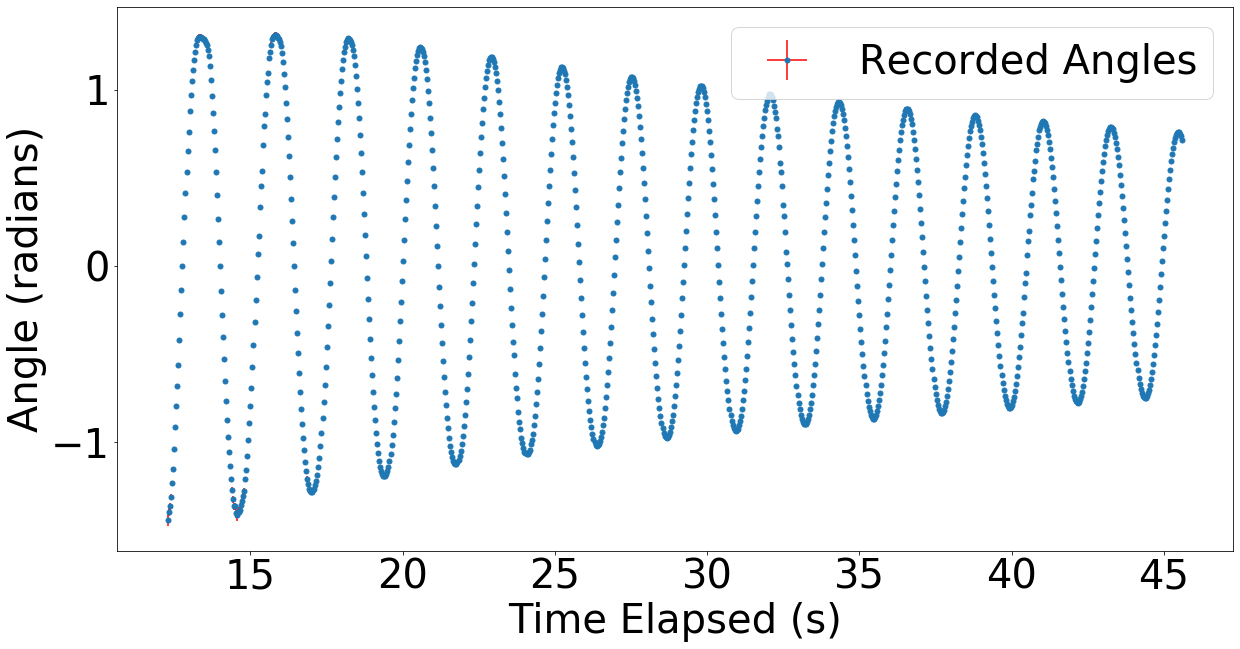

In [5]:
# First 1000
plot(t[:1000],theta[:1000],"first-1000")

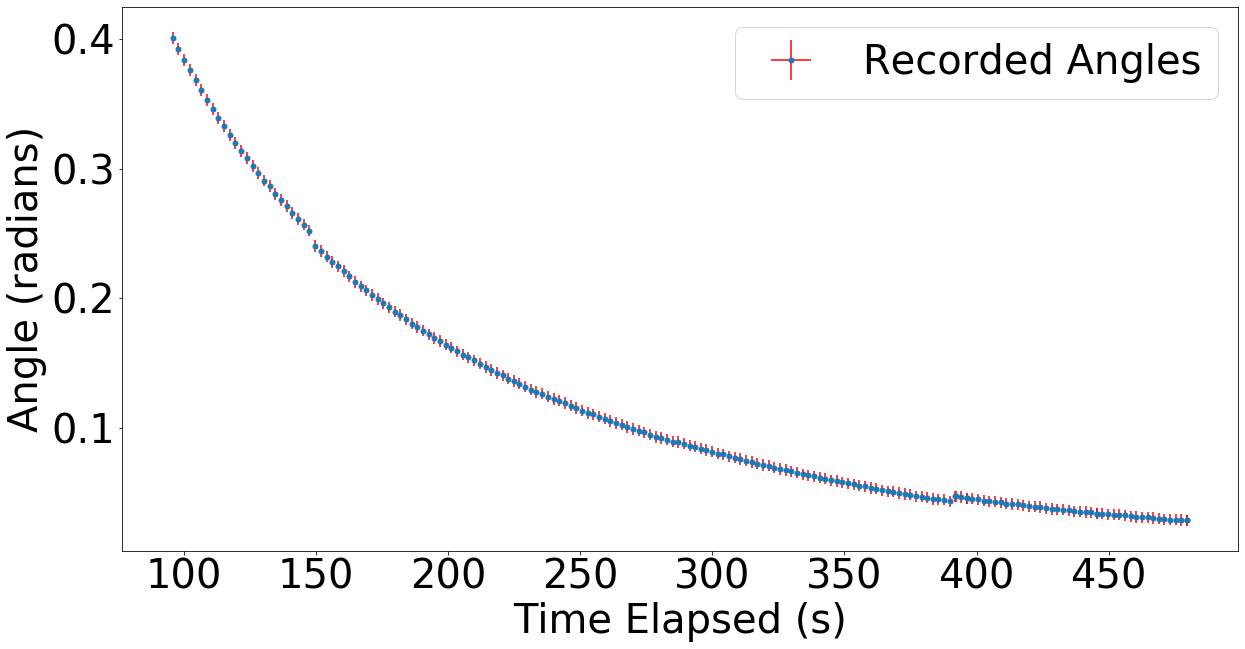

In [20]:
max_points = []
max_points_t = []
err_max_points = []
err_max_points_t = []

last_max = -99

for i in np.arange(2500,len(theta)-4):
    
    # Conditions to be met
    local_max_from_left = theta[i] > theta[i-1]
    local_max_from_right = theta[i] > theta[i+1]
    positive = theta[i] > 0
    local_max = local_max_from_left and local_max_from_right and positive

#     local_min_from_left = theta[i] < theta[i-1]
#     local_min_from_right = theta[i] < theta[i+1]
#     negative = theta[i] < 0
#     local_min = local_min_from_left and local_min_from_right and negative
    local_min = False
    
    # If conditions are met
    if local_max or local_min:
        
        if local_max:
            max_points.append(theta[i].nominal_value)
        else:
            max_points.append(-1*theta[i].nominal_value)
        max_points_t.append(t[i].nominal_value)
        err_max_points.append(theta[i].std_dev)
        err_max_points_t.append(t[i].std_dev)

max_points_t = np.asarray(max_points_t, dtype=np.float32)
max_points = np.asarray(max_points, dtype=np.float32)
err_max_points_t = np.asarray(err_max_points_t, dtype=np.float32)
err_max_points = np.asarray(err_max_points, dtype=np.float32)

# Convert to unumpy array for easy error propagation
max_points_t = unumpy.uarray(max_points_t, err_max_points_t)
max_points = unumpy.uarray(max_points, err_max_points)

plot(max_points_t,max_points,"amplitude-time")

In [22]:
max_points[0]*180/np.pi

22.95499367767994+/-0.2710576046766899

8 8
[-0.00676616 -0.42636987]
0.653+/-0.008 147.8+/-0.9
R^2:  0.9931634743197418


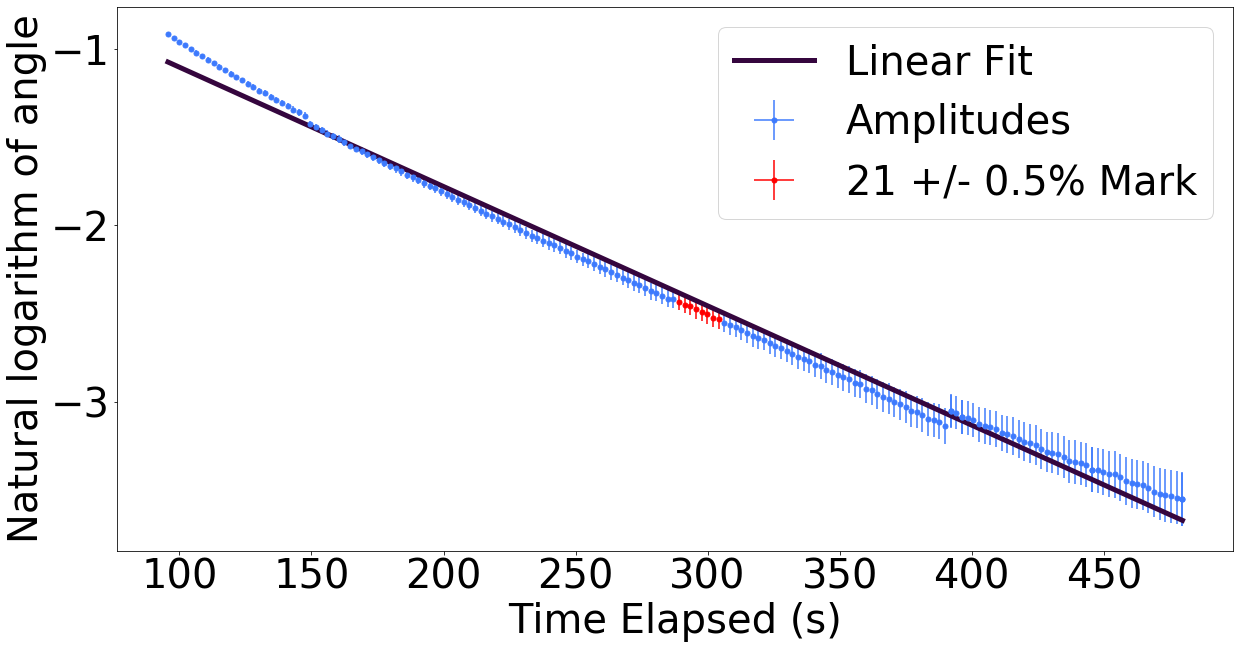

In [26]:
# Guesses
amplitude_tau = ufloat(131.726793,0)
amplitude_a = ufloat(0.36254742,0)

def unumpy_to_np(unumpy_arr):
    '''
    Helper function to unpack a unumpy array
    '''
    nominal_values = np.array([unumpy_arr[i].nominal_value for i in range(0,len(unumpy_arr))])
    errors = np.array([unumpy_arr[i].std_dev for i in range(0,len(unumpy_arr))])
    return nominal_values, errors

def amplitude_linear_drag(t, a, tau): 
    return a*np.exp(-t/tau)

N = 2
def fit_amplitude_to_f(t_points,theta_points):
    global amplitude_tau, amplitude_a
    
    '''
    PART ONE: GENERATE GRAPH
    '''
    temp_t_points, t_err = unumpy_to_np(t_points)
    temp_theta_points, theta_err = unumpy_to_np(unumpy.log(theta_points))
    
    # Get Parameters
    slope, intercept, r_value, p_value, std_err = stats.linregress(temp_t_points,temp_theta_points)
    
    # Fitting Function
    theta_fit = intercept+slope*temp_t_points

    theta_fit_not_t = np.array([])
    theta_fit_not = np.array([])
    theta_fit_not_theta_err  = np.array([])
    theta_fit_not_t_err = np.array([])
    
    theta_fit_yes_t = np.array([]) 
    theta_fit_yes = np.array([]) 
    theta_fit_yes_theta_err  = np.array([])
    theta_fit_yes_t_err = np.array([])
    for i in range(len(temp_theta_points)):
        if abs(np.exp(-np.pi/N)*max(theta_points)-np.exp(temp_theta_points[i])) < 0.005:
            theta_fit_not = np.append(theta_fit_not, temp_theta_points[i])
            theta_fit_not_t = np.append(theta_fit_not_t, temp_t_points[i])
            theta_fit_not_theta_err = np.append(theta_fit_not_theta_err, theta_err[i])
            theta_fit_not_t_err = np.append(theta_fit_not_t_err, t_err[i])

        else:
            theta_fit_yes = np.append(theta_fit_yes, temp_theta_points[i])
            theta_fit_yes_t = np.append(theta_fit_yes_t, temp_t_points[i])
            theta_fit_yes_theta_err = np.append(theta_fit_yes_theta_err, theta_err[i])
            theta_fit_yes_t_err = np.append(theta_fit_yes_t_err, t_err[i])

    print(len(theta_fit_not_t),len(theta_fit_not))
    # Plot
    plt.figure(figsize=(20,10))
    plt.xlabel("Time Elapsed (s)")
    plt.ylabel("Natural logarithm of angle")
    plt.errorbar(theta_fit_yes_t, theta_fit_yes, yerr=theta_fit_yes_theta_err, xerr=theta_fit_yes_t_err, color="xkcd:lightish blue", fmt='o', ms=5, label="Amplitudes")
    plt.errorbar(theta_fit_not_t, theta_fit_not, yerr=theta_fit_not_theta_err, xerr=theta_fit_not_t_err, color="red", fmt='o', ms=5, label="21 +/- 0.5% Mark")
    plt.plot(temp_t_points, theta_fit, label="Linear Fit", linewidth=5, color="xkcd:dark purple")
    plt.legend()
    plt.savefig("figures/amplitude-vs-time-fitted", dpi=300)

    
    '''
    PART TWO: GET PARAMATER UNCERTAINTIES
    '''

    z, cov = np.polyfit(temp_t_points, temp_theta_points, 1, cov=True)
    print(z)

    slope = ufloat(-z[0],cov[0,0]**0.5)
    amplitude_tau = 1/slope
    
    intercept = ufloat(z[1],cov[1,1]**0.5)
    amplitude_a = unumpy.exp(intercept)
    print(amplitude_a, amplitude_tau)
    print("R^2: ",r_value**2)

# Call the Function
fit_amplitude_to_f(max_points_t, max_points)

In [8]:
period = 2.14

print("Q1: ",np.pi*amplitude_tau/period)

N = 2
theta0 = max_points[0]

possible_values = [max_points_t[i] for i in range(len(max_points)) if (abs(np.exp(-np.pi/N)*theta0-max_points[i])<0.003)]

q2_min = N*min(possible_values)/period
q2_max = N*max(possible_values)/period
print("Q2 min: ",q2_min)
print("Q2 max: ",q2_max)

q2_avg = ((q2_min+q2_max)/2).n
q2_u = ((q2_max-q2_min)/2).n
print("Q2 average: ",ufloat(q2_avg,q2_u))

# Find weighted average:
print("Q weighted average:",0.5*(ufloat(q2_avg,q2_u)+np.pi*amplitude_tau/period))


Q1:  217.0+/-1.3
Q2 min:  274.299+/-0.009
Q2 max:  280.312+/-0.009
Q2 average:  277.3+/-3.0
Q weighted average: 247.1+/-1.6


# Get Period Graph

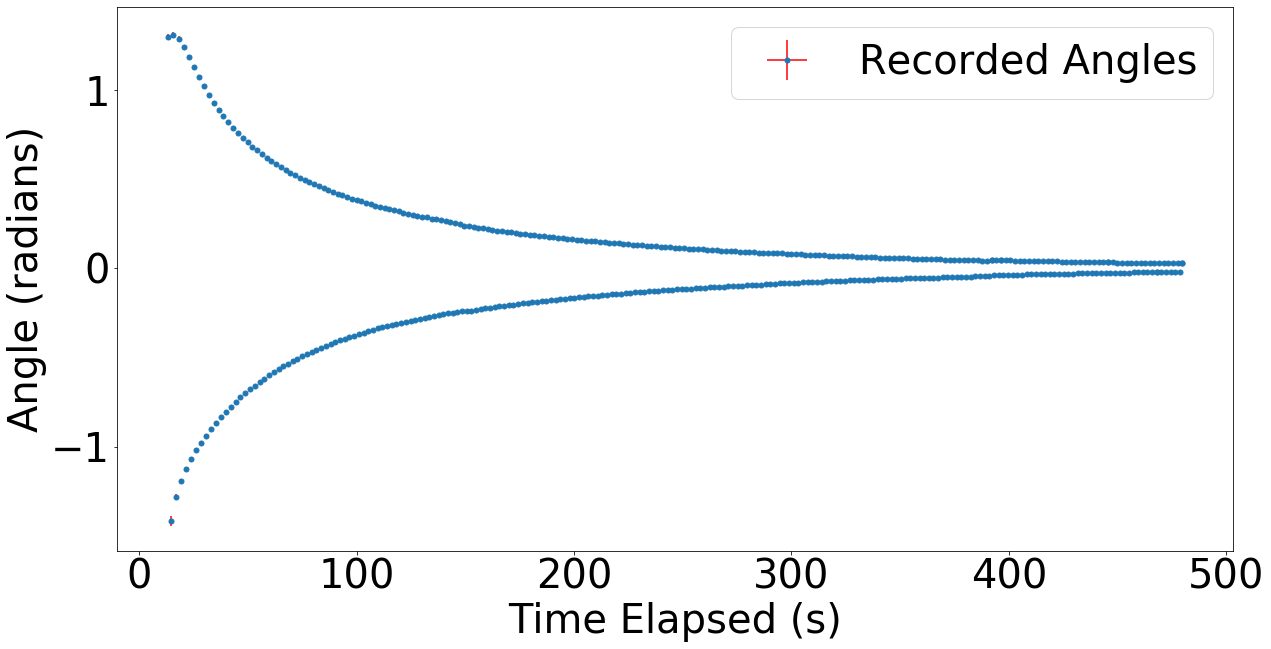

In [9]:
max_points = []
max_points_t = []
err_max_points = []
err_max_points_t = []

for i in np.arange(1,len(theta)-1):
    
    # Conditions to be met
    local_max_from_left = theta[i] > theta[i-1]
    local_max_from_right = theta[i] > theta[i+1]
    positive = theta[i] > 0
    local_max = local_max_from_left and local_max_from_right and positive

    # Conditions to be met
    local_min_from_left = theta[i] < theta[i-1]
    local_min_from_right = theta[i] < theta[i+1]
    negative = theta[i] < 0
    local_min = local_min_from_left and local_min_from_right and negative
    
    
    # If conditions are met
    if local_max or local_min:
        max_points.append(theta[i].nominal_value)
        max_points_t.append(t[i].nominal_value)
        err_max_points.append(theta[i].std_dev)
        err_max_points_t.append(t[i].std_dev)

max_points_t = np.asarray(max_points_t, dtype=np.float32)
max_points = np.asarray(max_points, dtype=np.float32)
err_max_points_t = np.asarray(err_max_points_t, dtype=np.float32)
err_max_points = np.asarray(err_max_points, dtype=np.float32)

# Convert to unumpy array for easy error propagation
max_points_t = unumpy.uarray(max_points_t, err_max_points_t)
max_points = unumpy.uarray(max_points, err_max_points)

plot(max_points_t,max_points,"amplitude-time")

In [10]:
sorted(max_points)[0]

-1.4163033962249756+/-0.0288364477455616

In [11]:
periods = []
periods_err = []
amplitudes = []
amplitudes_err = []


amplitude_range = np.array([min(max_points).n])
current_angle = min(max_points).n
for i in np.arange(min(max_points).n,max(max_points).n,0.001):
    if abs(i-current_angle) > 0.2:
        current_angle = i
        amplitude_range = np.append(amplitude_range,i)
amplitude_range = np.append(amplitude_range,max(max_points).n)

amplitude_midpoints = np.array([])
amplitude_midpoints_err = np.array([])

amplitude_bins = np.array([])

for i in range(len(amplitude_range)-1):
    current_bin = np.array([])
    current_amplitude_midpoint = np.array([])

    for amplitude in range(1,len(max_points)):
        if abs(max_points_t[amplitude]-max_points_t[amplitude-1]) > 0.4:
            if amplitude_range[i] < max_points[amplitude] < amplitude_range[i+1]:
                current_bin = np.append(current_bin,max_points_t[amplitude]-max_points_t[amplitude-1])
                current_amplitude_midpoint = np.append(current_amplitude_midpoint,max_points[amplitude].n)

    if not len(current_bin) == 0:
        amplitude_bins = np.append(amplitude_bins,sum(current_bin)/len(current_bin))
        amplitude_midpoints = np.append(amplitude_midpoints,0.5*(amplitude_range[i]+amplitude_range[i+1]))
        amplitude_midpoints_err = np.append(amplitude_midpoints_err,max(np.std(current_amplitude_midpoint),0.005))

display_y = np.array([2*amplitude_bins[i].nominal_value for i in range(0,len(amplitude_bins))])
y_err = np.array([amplitude_bins[i].std_dev for i in range(0,len(amplitude_bins))])


[2.1398882290600483+/-0.005495713501115519
 -0.003050062627879447+/-0.004149183130238007
 0.1433625860579876+/-0.0015363291821722527]
2.140+/-0.005 -0.0014+/-0.0019 0.0670+/-0.0007


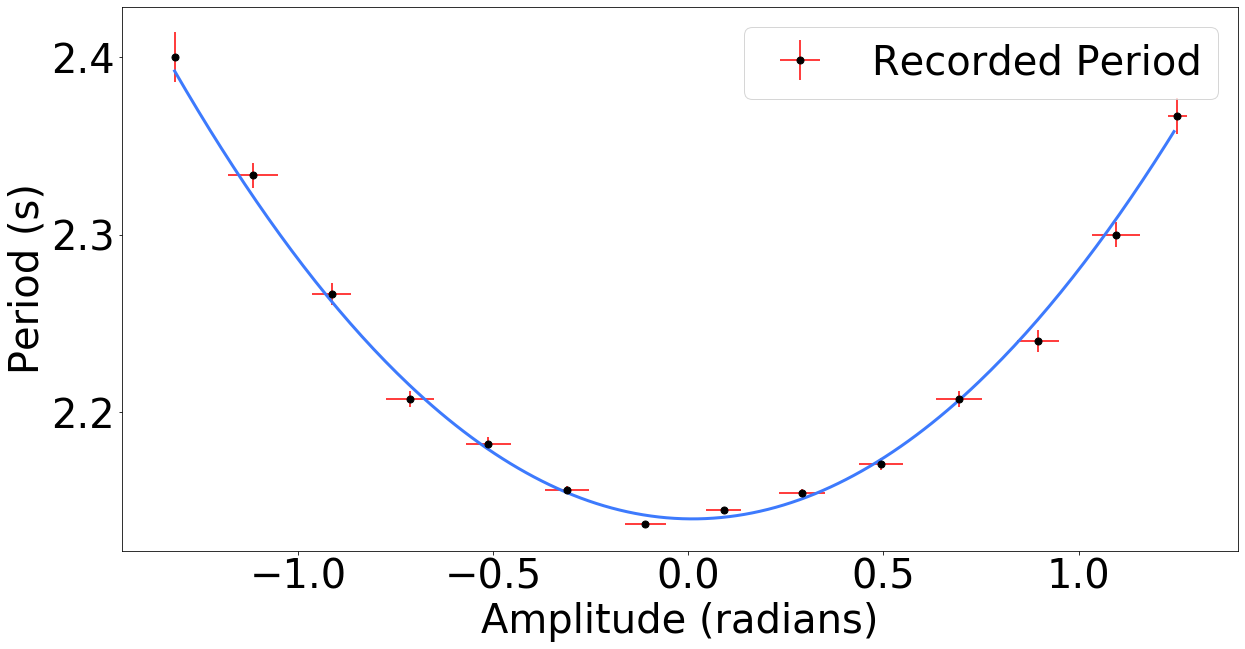

In [12]:
def period(angle, T0, alpha, beta): 
#     a = abs(amplitude_a).n
#     tau = abs(amplitude_tau).n
    return T0*(1+alpha*angle+beta*angle**2)


params,cov = np.polyfit(amplitude_midpoints, display_y, 2, rcond=None, cov=True, w=1/y_err)
params = params[::-1]
plt.figure(figsize=(20,10))
plt.errorbar( amplitude_midpoints, display_y, label="Recorded Period", yerr=y_err,xerr=amplitude_midpoints_err, fmt='o', ecolor="red", color="black", ms=7)

fit_x_values = np.arange(min(amplitude_midpoints),max(amplitude_midpoints),0.01)
fit_y_values = params[0]+params[1]*fit_x_values+params[2]*fit_x_values**2
plt.plot(fit_x_values, fit_y_values, color="xkcd:lightish blue",linewidth=3)
# plt.plot(amplitude_midpoints, amplitude_bins)

plt.xlabel("Amplitude (radians)")
plt.ylabel("Period (s)")
plt.legend(loc="upper right")
plt.savefig("Figures/period-vs-amplitude", dpi=300)


p = unumpy.uarray(params, np.sqrt(np.diag(cov)))
print(p)
print(p[0],p[1]/p[0],p[2]/p[0])
# param, param_cov = curve_fit(period, amplitude_midpoints, display_y) # p0=[2.4,0]
    
#     # Parameter Uncertainties
#     u_w = param_cov[0,0]**0.5
#     u_phi = param_cov[1,1]**0.5

#     # Fited Function
#     theta_fit = f(temp_t_points, param[0], param[1])

#     figure_w = ufloat(param[0],u_w)
#     figure_phi = ufloat(param[1],u_phi)

# fit_curve_to_f(sine_linear_drag, t, theta)

[2.1402456201836335+/-0.011965223889906878
 0.004981753605561042+/-0.007967616507535557
 0.1364165849428855+/-0.014675396254750983
 -0.011791789490578622+/-0.006799427944876366
 0.006248958128260535+/-0.0016295715110769301]
2.140+/-0.012 0.002+/-0.004 0.064+/-0.007 -0.0055+/-0.0032 0.0029+/-0.0008


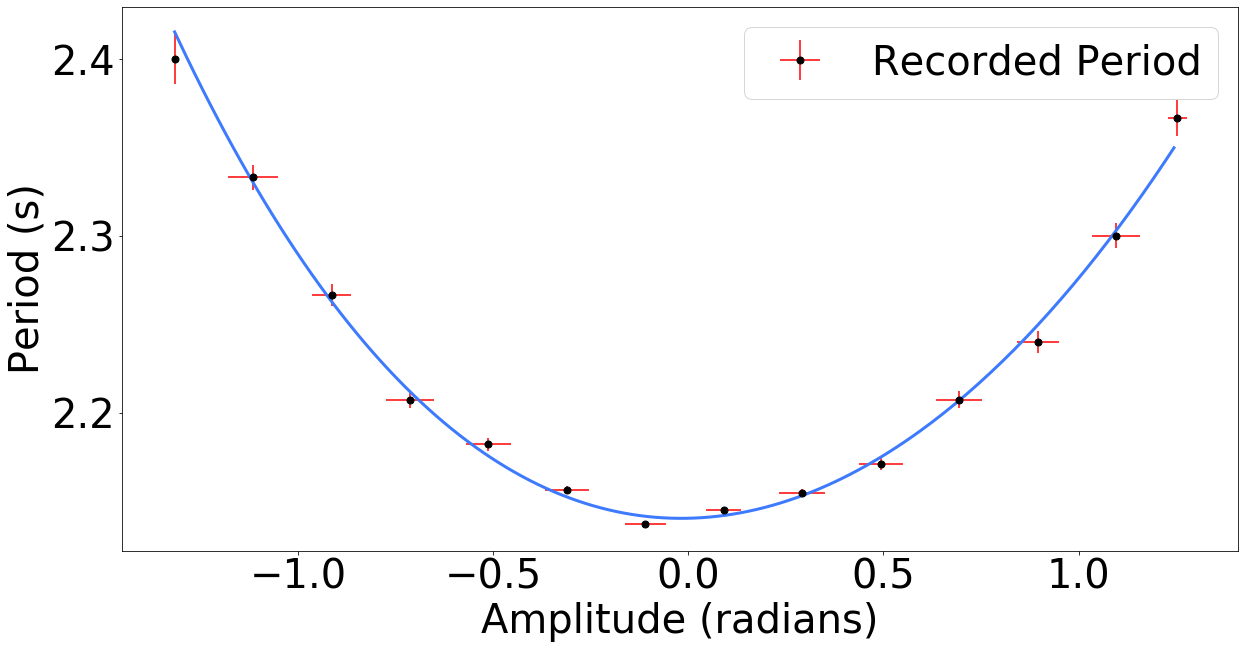

In [13]:
def period(angle, T0, alpha, beta): 
#     a = abs(amplitude_a).n
#     tau = abs(amplitude_tau).n
    return T0*(1+alpha*angle+beta*angle**2)


params,cov = np.polyfit(amplitude_midpoints, display_y, 4, rcond=None, cov=True, w=1/y_err)
params = params[::-1]
plt.figure(figsize=(20,10))
plt.errorbar( amplitude_midpoints, display_y, label="Recorded Period", yerr=y_err,xerr=amplitude_midpoints_err, fmt='o', ecolor="red", color="black", ms=7)

fit_x_values = np.arange(min(amplitude_midpoints),max(amplitude_midpoints),0.01)
fit_y_values = params[0]+params[1]*fit_x_values+params[2]*fit_x_values**2+params[3]*fit_x_values**3+params[4]*fit_x_values**4
plt.plot(fit_x_values, fit_y_values, color="xkcd:lightish blue",linewidth=3)
# plt.plot(amplitude_midpoints, amplitude_bins)

plt.xlabel("Amplitude (radians)")
plt.ylabel("Period (s)")
plt.legend(loc="upper right")
plt.savefig("Figures/period-vs-amplitude-quartic", dpi=300)


p = unumpy.uarray(params, np.sqrt(np.diag(cov)))
print(p)
print(p[0],p[1]/p[0],p[2]/p[0],p[3]/p[0],p[4]/p[0])
# param, param_cov = curve_fit(period, amplitude_midpoints, display_y) # p0=[2.4,0]
    
#     # Parameter Uncertainties
#     u_w = param_cov[0,0]**0.5
#     u_phi = param_cov[1,1]**0.5

#     # Fited Function
#     theta_fit = f(temp_t_points, param[0], param[1])

#     figure_w = ufloat(param[0],u_w)
#     figure_phi = ufloat(param[1],u_phi)

# fit_curve_to_f(sine_linear_drag, t, theta)

[2.139912030579619+/-0.0053880453836282005
 0.14327080456181793+/-0.0015062847427896346]
0.0670+/-0.0007


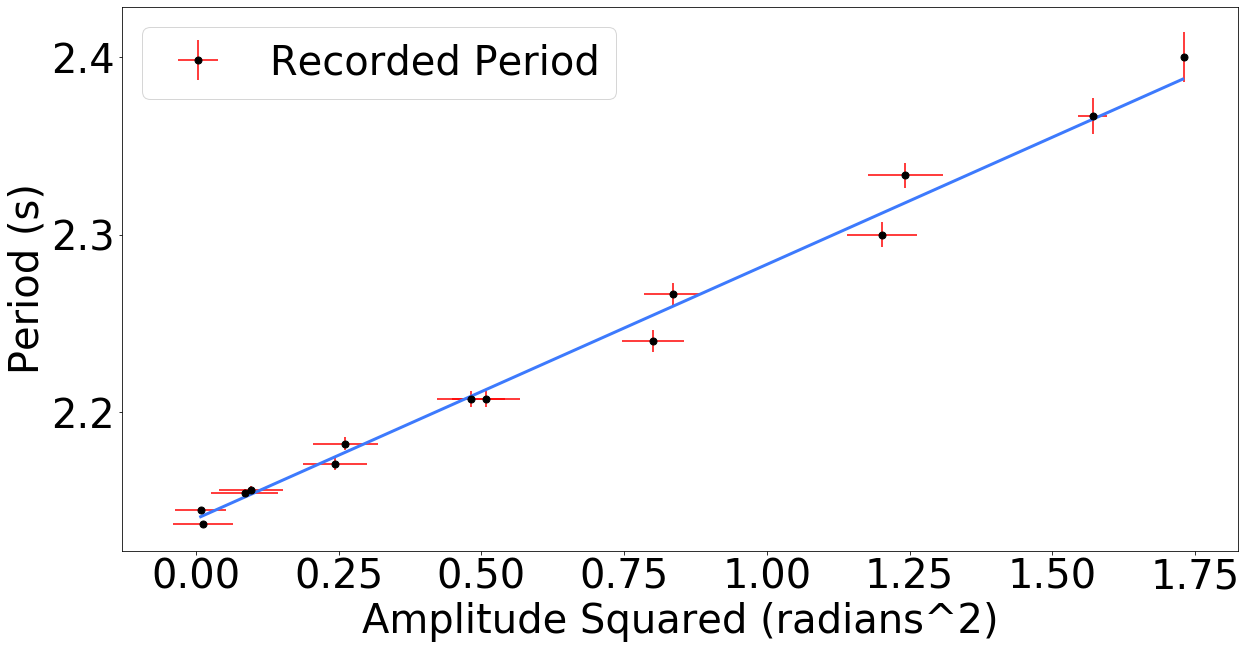

In [14]:
def period(angle, T0, alpha, beta): 
#     a = abs(amplitude_a).n
#     tau = abs(amplitude_tau).n
    return T0*(1+alpha*angle+beta*angle**2)


params,cov = np.polyfit(amplitude_midpoints*amplitude_midpoints, display_y, 1, rcond=None, cov=True,w=1/y_err)
params = params[::-1]
plt.figure(figsize=(20,10))
plt.errorbar(amplitude_midpoints*amplitude_midpoints, display_y, label="Recorded Period", yerr=y_err,xerr=amplitude_midpoints_err, fmt='o', ecolor="red", color="black", ms=7)

fit_x_values = np.arange(min(amplitude_midpoints*amplitude_midpoints),max(amplitude_midpoints*amplitude_midpoints),0.01)
fit_y_values = params[0]+params[1]*fit_x_values
plt.plot(fit_x_values, fit_y_values, color="xkcd:lightish blue",linewidth=3)
# plt.plot(amplitude_midpoints, amplitude_bins)

plt.xlabel("Amplitude Squared (radians^2)")
plt.ylabel("Period (s)")
plt.legend(loc="upper left")
plt.savefig("Figures/period-vs-amplitude-linear", dpi=300)


p = unumpy.uarray(params, np.sqrt(np.diag(cov)))
print(p)
print(p[1]/p[0])
# param, param_cov = curve_fit(period, amplitude_midpoints, display_y) # p0=[2.4,0]
    
#     # Parameter Uncertainties
#     u_w = param_cov[0,0]**0.5
#     u_phi = param_cov[1,1]**0.5

#     # Fited Function
#     theta_fit = f(temp_t_points, param[0], param[1])

#     figure_w = ufloat(param[0],u_w)
#     figure_phi = ufloat(param[1],u_phi)

# fit_curve_to_f(sine_linear_drag, t, theta)

In [15]:
slope, intercept, r_value, p_value, std_err = stats.linregress(amplitude_midpoints*amplitude_midpoints,display_y)
r_value**2

0.9912100266992238